In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import copy
from scipy.interpolate import interp1d
%matplotlib ipympl
from freeflyer import FreeflyerModel, ocp_no_obstacle_avoidance, ocp_obstacle_avoidance, sample_init_target
from freeflyer import ff as ff_scenario

## Old implementation

In [ ]:
class FreeFlyer():

    def __init__(self):
        # Initialization 
        self.n_state = 6
        self.n_action = 3
        self.n_clusters = 4
        self.mass = 16 # kg
        self.radius = 0.15 # m
        self.J = 0.18 # kg*m^2
        self.b_t = 0.11461 # m
        self.F_t_M = 0.2 # N
        self.F_B_M = 2*0.2 # N
        self.M_B_M = 4*self.F_t_M*self.b_t # N*m
        self.dt_sim = 0.1 # s
        self.A = np.array([[0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0],
                           [1/self.mass, 0, 0],
                           [0, 1/self.mass, 0],
                           [0, 0, 1/self.J]])
        self.Lambda = np.array([[       0,         1,         0,        1],
                                [       1,         0,         1,        0],
                                [self.b_t, -self.b_t, -self.b_t, self.b_t]])
        self.Lambda_inv = np.array([[  0, 0.5,  1/(4*self.b_t)],
                                    [0.5,   0, -1/(4*self.b_t)],
                                    [  0, 0.5, -1/(4*self.b_t)],
                                    [0.5,   0,  1/(4*self.b_t)]])

        # Optimization methods
        param = {
            'mass' : self.mass,
            'J' : self.J,
            'radius' : self.radius,
            'F_t_M' : self.F_t_M,
            'b_t' : self.b_t,
            'F_B_M' : self.F_B_M,
            'M_B_M' : self.M_B_M,
            'Lambda_inv' : self.Lambda_inv
        }
        self.iocp = ImpulsiveOCP2(self.n_state, self.n_action, param)

    def feed_impulsive_control(self, state_init, planned_traj):
        # Extraction
        tt = planned_traj['time']
        planned_states = planned_traj['states']
        imp_actions_t = planned_traj['actions_t']
        dt_opt = tt[1] - tt[0]
        
        # Compute thrusters firing time
        sign_on = np.sign(imp_actions_t)
        t_on = np.round(np.abs(imp_actions_t)*self.mass/self.F_t_M, decimals=2)
        tt_sim = np.arange(0, tt[-1]+self.dt_sim/2, self.dt_sim)
        actions_t = np.zeros((self.n_clusters, len(tt_sim)-1))
        dt_to_next_dt_opt = np.vstack((np.arange(0, dt_opt, self.dt_sim), np.arange(0, dt_opt, self.dt_sim), np.arange(0, dt_opt, self.dt_sim), np.arange(0, dt_opt, self.dt_sim)))
        dt_sim_x_dt_opt = dt_to_next_dt_opt.shape[1]
        for i in range(t_on.shape[1]):
            mask = sign_on[:,i:i+1]*(dt_to_next_dt_opt < t_on[:,i:i+1])
            actions_t[:,i*dt_sim_x_dt_opt:(i+1)*dt_sim_x_dt_opt] = mask * np.array([self.F_t_M, self.F_t_M, self.F_t_M, self.F_t_M]).reshape(self.n_clusters, 1)

        # States propagation
        states = np.zeros((self.n_state, len(tt_sim)))
        actions_G = np.zeros((self.n_action, len(tt_sim)-1))
        states[:,0] = state_init
        for i in range(len(tt_sim)-1):
            actions_G[:,i] = (R_GB(states[2,i]) @ (self.Lambda @ actions_t[:,i]))
            states[:,i+1] = states[:,i] + (self.A @ states[:,i] + self.B @ actions_G[:,i])*self.dt_sim
        traj_sim = {
            'time' : tt_sim,
            'states' : states,
            'actions_G' : actions_G,
            'actions_t' : actions_t
        }
        traj_ref = {
            'time' : tt,
            'states' : planned_states
        }

        return traj_sim, traj_ref

    def feed_sliding_mode_control(self, state_init, planned_traj):
        # Extraction
        tt = planned_traj['time']
        planned_states = planned_traj['states']
        imp_actions_G = planned_traj['actions_G']
        imp_actions_t = planned_traj['actions_t']
        dt_opt = tt[1] - tt[0]
        
        # States propagation
        tt_sim = np.arange(0, tt[-1]+self.dt_sim/2, self.dt_sim)
        states = np.zeros((self.n_state, len(tt_sim)))
        states_f = interp1d(tt, planned_states)
        states_ref = states_f(tt_sim)
        actions_G = np.zeros((self.n_action, len(tt_sim)-1))
        actions_t = np.zeros((self.n_clusters, len(tt_sim)-1))
        states[:,0] = state_init
        for i in range(len(tt_sim)-1):
            e_p = (states[:3,i] - states_ref[:3,i])
            e_v = (states[3:,i] - states_ref[3:,i])
            e_v[abs(e_v) < 5e-3] = 0
            e_t = self.Lambda_inv @ (R_BG(states[2,i]) @ e_v)
            actions_t[:,i] = - self.F_t_M * np.sign(e_t)
            actions_G[:,i] = (R_GB(states[2,i]) @ (self.Lambda @ actions_t[:,i]))
            states[:,i+1] = states[:,i] + (self.A @ states[:,i] + self.B @ actions_G[:,i])*self.dt_sim
        traj_sim = {
            'time' : tt_sim,
            'states' : states,
            'actions_G' : actions_G,
            'actions_t' : actions_t
        }
        traj_ref = {
            'time' : tt_sim,
            'states' : states_ref
        }

        return traj_sim, traj_ref
    
    def plot_scenario(self, trajectory, obs, state_init, state_final, traj_ref=None):
        # Extraction
        tt = trajectory['time']
        states = trajectory['states']
        actions = trajectory['actions_G']
        actions_t = trajectory['actions_t']
        if traj_ref is not None:
            tt_ref = traj_ref['time']
            states_ref = traj_ref['states']

        fig, ax = plt.subplots()
        ax.plot(states[0,:], states[1,:], label='scp')
        ax.add_patch(Circle(obs['position'][0], obs['radius'][0], fc='r', label='obs'))
        ax.scatter(state_init[0], state_init[1], label='state init')
        ax.scatter(state_final[0], state_final[1], label='state final')
        ax.grid(True)
        ax.set_aspect('equal')
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        
        fig2, ax2 = plt.subplots(3,2,figsize=(20,15))
        ax2[0,0].plot(tt, states[:3,:].T)
        ax2[0,0].grid(True)
        ax2[0,0].set_ylabel('$ x, y, \psi$')
        ax2[0,0].set_xlabel('time [s]')
        ax2[0,1].plot(tt, states[3:,:].T)
        ax2[0,1].grid(True)
        ax2[0,1].set_ylabel('$ \dot{x}, \dot{y}, \dot{\psi}$')
        ax2[0,1].set_xlabel('time [s]')
        if traj_ref is not None:
            ax2[0,1].plot(tt_ref, states_ref[3:,:].T)

        ax2[1,0].stem(tt[:-1], actions[0,:], linefmt='C0', markerfmt='C0o')
        ax2[1,0].stem(tt[:-1], actions[1,:], linefmt='C1', markerfmt='C1o')
        ax2[1,0].stem(tt[:-1], actions[2,:], linefmt='C2', markerfmt='C2o')
        ax2[1,0].grid(True)
        ax2[1,0].set_ylabel('$\Delta V_{G}$')
        ax2[1,0].set_xlabel('time [s]')

        actions_B = (R_BG(states[2,:-1]) @ actions[:,None,:].transpose(2,0,1))[:,:,0].T
        ax2[1,1].stem(tt[:-1], actions_B[0,:], linefmt='C0', markerfmt='C0o')
        ax2[1,1].stem(tt[:-1], actions_B[1,:], linefmt='C1', markerfmt='C1o')
        ax2[1,1].stem(tt[:-1], actions_B[2,:], linefmt='C2', markerfmt='C2o')
        ax2[1,1].grid(True)
        ax2[1,1].set_ylabel('$\Delta V_{B}$')
        ax2[1,1].set_xlabel('time [s]')

        actions_t2 = self.Lambda_inv @ actions_B
        sep = np.max(actions_t)*1.1
        ax2[2,0].stem(tt[:-1], 0+actions_t[0,:], linefmt='C0', markerfmt='C0o', bottom=0)
        ax2[2,0].stem(tt[:-1], 2*sep+actions_t[1,:], linefmt='C1', markerfmt='C1o', bottom=2*sep)
        ax2[2,0].stem(tt[:-1], 4*sep+actions_t[2,:], linefmt='C2', markerfmt='C2o', bottom=4*sep)
        ax2[2,0].stem(tt[:-1], 6*sep+actions_t[3,:], linefmt='C3', markerfmt='C3o', bottom=6*sep)
        ax2[2,0].stem(tt[:-1], 0+actions_t2[0,:], linefmt='k', markerfmt='k*', bottom=0)
        ax2[2,0].stem(tt[:-1], 2*sep+actions_t2[1,:], linefmt='k', markerfmt='k*', bottom=2*sep)
        ax2[2,0].stem(tt[:-1], 4*sep+actions_t2[2,:], linefmt='k', markerfmt='k*', bottom=4*sep)
        ax2[2,0].stem(tt[:-1], 6*sep+actions_t2[3,:], linefmt='k', markerfmt='k*', bottom=6*sep)
        ax2[2,0].grid(True)
        ax2[2,0].set_ylabel('$\Delta V_{B}$')
        ax2[2,0].set_xlabel('time [s]')

class ImpulsiveOCP():

    # SCP param
    iter_max_SCP = 20
    trust_region0 = 10
    trust_regionf = 0.01
    J_tol= 1e-6

    def __init__(self, n_state, n_action, param):
        self.n_state = n_state
        self.n_action = n_action
        # Linear system for optimization with impulsive DeltaV, DeltaPSI_dot
        self.A = np.array([[0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0, 0],
                           [0, 0, 0],
                           [0, 0, 0],
                           [1, 0, 0],
                           [0, 1, 0],
                           [0, 0, 1]])
        self.param = param
        
    def set_Ak(self, dt):
        self.Ak = np.eye(self.n_state, self.n_state) + dt*self.A
    
    def solve_scp(self, state_init, state_final, obs, total_time, n_timesteps):
        T = total_time
        dt = total_time/(n_timesteps-1)
        tt = np.arange(0,T+dt/2,dt)
        self.set_Ak(dt)
        state_ref = state_init[:,None] + ((state_final - state_init)[:,None]/T)*np.repeat(tt[None,:], self.n_state, axis=0)
        actions_bb = {
            'Dv_M' : self.param['F_B_M']*dt/self.param['mass'],
            'Dom_M' : self.param['M_B_M']*dt/self.param['J']
        }

        # Initial condition for the scp
        DELTA_J = 10
        trust_region = self.trust_region0
        beta_SCP = (self.trust_regionf/self.trust_region0)**(1/self.iter_max_SCP)
        J_vect = np.ones(shape=(self.iter_max_SCP,), dtype=float)*1e12

        for scp_iter in range(self.iter_max_SCP):
            # define and solve
            states_scp, actions_scp, J, feas_scp = self.ocp_scp(state_ref, state_init, state_final, actions_bb, obs, trust_region, n_timesteps-1)
            if feas_scp == 'infeasible':
                break
            J_vect[scp_iter] = J

            # compute error
            trust_error = np.max(np.linalg.norm(states_scp - state_ref, axis=0))
            if scp_iter > 0:
                DELTA_J = J_prev - J

            # Update iterations
            state_ref = states_scp
            action_ref = actions_scp
            J_prev = J
            trust_region = beta_SCP*trust_region
            if scp_iter >= 1 and (trust_error <= self.trust_regionf and abs(DELTA_J) < self.J_tol):
                break
        
        if feas_scp == 'infeasible':
            s_opt = None
            a_opt = None
            J = None
        else:
            s_opt = states_scp
            a_opt = actions_scp
        
        return tt, s_opt, a_opt, J_vect, scp_iter, feas_scp
    
    def ocp_scp(self, state_ref, state_init, state_final, actions_bb, obs, trust_region, n_time):
        s = cp.Variable((6,n_time))
        a = cp.Variable((3,n_time))

        # CONSTRAINTS
        constraints = []

        # Initial, dynamics and final state
        constraints += [s[:,0] == state_init]
        constraints += [s[:,k+1] == self.Ak @ (s[:,k] + self.B @ a[:,k]) for k in range(n_time-1)]
        constraints += [(s[:,-1] + self.B @ a[:,-1]) == state_final]
        # Actions bounding box
        constraints += [a[:2,:] >= -actions_bb['Dv_M']]
        constraints += [a[:2,:] <= actions_bb['Dv_M']]
        constraints += [a[2,:] >= -actions_bb['Dom_M']]
        constraints += [a[2,:] <= actions_bb['Dom_M']]
        # Trust region and koz 
        for k in range(1,n_time):
            # Trust region
            b_soc_k = -state_ref[:,k]
            constraints += [cp.SOC(trust_region, s[:,k] + b_soc_k)]
            # keep-out-zone
            c_koz_k = np.transpose(state_ref[:2,k] - obs['position']).dot(np.eye(2)/((obs['radius'])**2))
            b_koz_k = np.sqrt(c_koz_k.dot(state_ref[:2,k] - obs['position']))
            constraints += [c_koz_k @ (s[:2,k] - obs['position']) >= b_koz_k]
        
        # Cost function
        cost = cp.sum(cp.norm(a, 1, axis=0))

        # Problem formulation
        prob = cp.Problem(cp.Minimize(cost), constraints)

        prob.solve(solver=cp.ECOS, verbose=False)
        if prob.status == 'infeasible':
            print("[solve]: Problem infeasible.")
            s_opt = None
            a_opt = None
            J = None
        else:
            s_opt = s.value#np.hstack((s.value, x_final.reshape(-1,1))).T
            a_opt = a.value
            s_opt = np.vstack((s_opt.T, s_opt[:,-1] + self.B @ a_opt[:,-1])).T
            J = prob.value

        return s_opt, a_opt, J, prob.status

class ImpulsiveOCP2():

    # SCP param
    iter_max_SCP = 20
    trust_region0 = 10
    trust_regionf = 0.01
    J_tol= 1e-6

    def __init__(self, n_state, n_action, param):
        self.n_state = n_state
        self.n_action = n_action
        # Linear system for optimization with impulsive DeltaV, DeltaPSI_dot
        self.param = param
        self.A = np.array([[0, 0, 0, 1, 0, 0],
                           [0, 0, 0, 0, 1, 0],
                           [0, 0, 0, 0, 0, 1],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 0, 0]])
        self.B = np.array([[0, 0,                        0],
                           [0, 0,                        0],
                           [0, 0,                        0],
                           [1, 0,                        0],
                           [0, 1,                        0],
                           [0, 0, param['mass']/param['J']]])
        
        
    def set_Ak(self, dt):
        self.Ak = np.eye(self.n_state, self.n_state) + dt*self.A
    
    def action_bounding_box_lin(self, psi_ref, action_ref):
        A_bb = 0.5*np.array([-np.cos(psi_ref)*action_ref[0] - np.sin(psi_ref)*action_ref[1],
                             -np.sin(psi_ref)*action_ref[0] + np.cos(psi_ref)*action_ref[1],
                             -np.cos(psi_ref)*action_ref[0] - np.sin(psi_ref)*action_ref[1],
                             -np.sin(psi_ref)*action_ref[0] + np.cos(psi_ref)*action_ref[1]])
        B_bb = np.array([[-np.sin(psi_ref)/2, np.cos(psi_ref)/2,  1/(4*self.param['b_t'])],
                         [ np.cos(psi_ref)/2, np.sin(psi_ref)/2, -1/(4*self.param['b_t'])],
                         [-np.sin(psi_ref)/2, np.cos(psi_ref)/2, -1/(4*self.param['b_t'])],
                         [ np.cos(psi_ref)/2, np.sin(psi_ref)/2,  1/(4*self.param['b_t'])]])
        
        return A_bb, B_bb

    def solve_scp(self, state_init, state_final, obs, total_time, n_timesteps):
        T = total_time
        dt = total_time/(n_timesteps-1)
        tt = np.arange(0,T+dt/2,dt)
        self.set_Ak(dt)
        state_ref = state_init[:,None] + ((state_final - state_init)[:,None]/T)*np.repeat(tt[None,:], self.n_state, axis=0)
        action_ref = np.zeros((self.n_action, len(tt)-1))
        self.Dv_t_M = self.param['F_t_M']*dt/self.param['mass']
        obs = copy.deepcopy(obs)
        obs['radius'] = (obs['radius'] + self.param['radius'])*1.1

        # Initial condition for the scp
        DELTA_J = 10
        trust_region = self.trust_region0
        beta_SCP = (self.trust_regionf/self.trust_region0)**(1/self.iter_max_SCP)
        J_vect = np.ones(shape=(self.iter_max_SCP,), dtype=float)*1e12

        for scp_iter in range(self.iter_max_SCP):
            # define and solve
            states_scp, actions_scp, J, feas_scp = self.ocp_scp(state_ref, action_ref, state_init, state_final, obs, trust_region, n_timesteps-1)
            if feas_scp == 'infeasible':
                break
            J_vect[scp_iter] = J

            # compute error
            trust_error = np.max(np.linalg.norm(states_scp - state_ref, axis=0))
            if scp_iter > 0:
                DELTA_J = J_prev - J

            # Update iterations
            state_ref = states_scp
            action_ref = actions_scp
            J_prev = J
            trust_region = beta_SCP*trust_region
            if scp_iter >= 1 and (trust_error <= self.trust_regionf and abs(DELTA_J) < self.J_tol):
                break
        
        if feas_scp == 'infeasible':
            s_opt = None
            a_opt = None
            a_t_opt = None
            J = None
        else:
            s_opt = states_scp
            a_opt = actions_scp
            a_opt_t = self.param['Lambda_inv'] @ (R_BG(s_opt[2,:-1]) @ a_opt[:,None,:].transpose(2,0,1))[:,:,0].T
        
        traj_opt = {
            'time' : tt,
            'states' : s_opt,
            'actions_G' : a_opt,
            'actions_t' : a_opt_t
        }
        
        return traj_opt, J_vect, scp_iter, feas_scp
    
    def ocp_scp(self, state_ref, action_ref, state_init, state_final, obs, trust_region, n_time):
        s = cp.Variable((6,n_time))
        a = cp.Variable((3,n_time))

        # CONSTRAINTS
        constraints = []

        # Initial, dynamics and final state
        constraints += [s[:,0] == state_init]
        constraints += [s[:,k+1] == self.Ak @ (s[:,k] + self.B @ a[:,k]) for k in range(n_time-1)]
        constraints += [(s[:,-1] + self.B @ a[:,-1]) == state_final]
        # Trust region and koz and action bounding box
        for k in range(0,n_time):
            # Trust region
            b_soc_k = -state_ref[:,k]
            constraints += [cp.SOC(trust_region, s[:,k] + b_soc_k)]
            # keep-out-zone
            c_koz_k = np.transpose(state_ref[:2,k] - obs['position'][0,:]).dot(np.eye(2)/((obs['radius'][0])**2))
            b_koz_k = np.sqrt(c_koz_k.dot(state_ref[:2,k] - obs['position'][0,:]))
            constraints += [c_koz_k @ (s[:2,k] - obs['position'][0,:]) >= b_koz_k]
            # action_bounding_box
            A_bb_k, B_bb_k = self.action_bounding_box_lin(state_ref[2,k], action_ref[:,k])
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] >= -self.Dv_t_M]
            constraints += [A_bb_k*(s[2,k] - state_ref[2,k]) + B_bb_k@a[:,k] <= self.Dv_t_M]
        
        # Cost function
        cost = cp.sum(cp.norm(a, 1, axis=0))

        # Problem formulation
        prob = cp.Problem(cp.Minimize(cost), constraints)

        prob.solve(solver=cp.ECOS, verbose=False)
        if prob.status == 'infeasible':
            print("[solve]: Problem infeasible.")
            s_opt = None
            a_opt = None
            J = None
        else:
            s_opt = s.value#np.hstack((s.value, x_final.reshape(-1,1))).T
            a_opt = a.value
            s_opt = np.vstack((s_opt.T, s_opt[:,-1] + self.B @ a_opt[:,-1])).T
            J = prob.value

        return s_opt, a_opt, J, prob.status

def R_GB(psi): 
    try:
        R_GB = np.zeros((len(psi),3,3))
        cos_psi = np.cos(psi)
        sin_psi = np.sin(psi)
        R_GB[:,0,0] = cos_psi
        R_GB[:,1,1] = cos_psi
        R_GB[:,0,1] = -sin_psi
        R_GB[:,1,0] = sin_psi
        R_GB[:,2,2] = 1
    except:
        R_GB = np.array([[np.cos(psi), -np.sin(psi), 0],
                         [np.sin(psi),  np.cos(psi), 0],
                         [          0,            0, 1]])
    return R_GB
    
def R_BG(psi):
    try:
        R_BG = np.zeros((len(psi),3,3))
        cos_psi = np.cos(psi)
        sin_psi = np.sin(psi)
        R_BG[:,0,0] = cos_psi
        R_BG[:,1,1] = cos_psi
        R_BG[:,0,1] = sin_psi
        R_BG[:,1,0] = -sin_psi
        R_BG[:,2,2] = 1
    except:
        R_BG = np.array([[ np.cos(psi),  np.sin(psi), 0],
                         [-np.sin(psi),  np.cos(psi), 0],
                         [           0,            0, 1]])
    return R_BG

In [ ]:
T = 40
n_time = 101
ff = FreeFlyer()
state_init = np.array([0,0,0,0,0,0])
state_final = np.array([5.,0,np.pi,0,0,0])
obs = {
    'position' : np.array([[(state_init[0] + state_final[0])/2, +0.5]]),
    'radius' : np.array([1])
}

In [ ]:
traj_scp, J_vect_scp, iter_scp, feas_scp = ff.iocp.solve_scp(state_init, state_final, obs, T, n_time)

In [ ]:
iter_scp, ff.F_t_M*0.36/ff.mass

In [ ]:
ff.plot_scenario(traj_scp, obs, state_init, state_final)

In [ ]:
traj_sim, traj_ref = ff.feed_impulsive_control(state_init, traj_scp)
#traj_sim, traj_ref = ff.feed_sliding_mode_control(state_init, traj_scp)

In [ ]:
ff.plot_scenario(traj_sim, obs, state_init, state_final, traj_ref=traj_ref)

## New implementation for dataset gen

In [21]:
ff = FreeflyerModel(verbose=True)
state_init = np.array([0.2,0.5,0,0,0,0])
state_final = np.array([3.2,2.,np.pi,0,0,0])
#state_init, state_final = sample_init_target()
#state_init, state_final

Initializing freeflyer class.


In [22]:
traj_rel, J, iter_rel, feas_rel = ocp_no_obstacle_avoidance(ff, state_init, state_final)

In [23]:
iter_rel, J

(2, 0.24356710155783434)

In [24]:
def plot_scenario(trajectory, obs, state_init, state_final, traj_ref=None):
    # Extraction
    tt = trajectory['time']
    states = trajectory['states']
    actions = trajectory['actions_G']
    actions_t = trajectory['actions_t']
    if traj_ref is not None:
        tt_ref = traj_ref['time']
        states_ref = traj_ref['states']

    fig, ax = plt.subplots()
    ax.plot(states[0,:], states[1,:], label='scp', zorder=3)
    ax.add_patch(Rectangle((0,0), ff_scenario.table['xy_up'][0], ff_scenario.table['xy_up'][1], fc=(0.5,0.5,0.5,0.2), ec='k', label='table', zorder=2.5))
    for n_obs in range(len(obs['radius'])):
        ax.add_patch(Circle(obs['position'][n_obs,:], obs['radius'][n_obs], fc='r', label='obs', zorder=2.5))
        ax.add_patch(Circle(obs['position'][n_obs,:], obs['radius'][n_obs]+ff.param['radius'], fc='r', alpha=0.2, zorder=2.5))
    ax.scatter(state_init[0], state_init[1], label='state init', zorder=3)
    ax.scatter(state_final[0], state_final[1], label='state final', zorder=3)
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    
    fig2, ax2 = plt.subplots(3,2,figsize=(20,15))
    ax2[0,0].plot(tt, states[:3,:].T)
    ax2[0,0].grid(True)
    ax2[0,0].set_ylabel('$ x, y, \psi$')
    ax2[0,0].set_xlabel('time [s]')
    ax2[0,1].plot(tt, states[3:,:].T)
    ax2[0,1].grid(True)
    ax2[0,1].set_ylabel('$ \dot{x}, \dot{y}, \dot{\psi}$')
    ax2[0,1].set_xlabel('time [s]')
    if traj_ref is not None:
        ax2[0,1].plot(tt_ref, states_ref[3:,:].T)

    ax2[1,0].stem(tt[:-1], actions[0,:], linefmt='C0', markerfmt='C0o')
    ax2[1,0].stem(tt[:-1], actions[1,:], linefmt='C1', markerfmt='C1o')
    ax2[1,0].stem(tt[:-1], actions[2,:], linefmt='C2', markerfmt='C2o')
    ax2[1,0].grid(True)
    ax2[1,0].set_ylabel('$\Delta V_{G}$')
    ax2[1,0].set_xlabel('time [s]')

    actions_B = (ff.R_BG(states[2,:-1]) @ actions[:,None,:].transpose(2,0,1))[:,:,0].T
    ax2[1,1].stem(tt[:-1], actions_B[0,:], linefmt='C0', markerfmt='C0o')
    ax2[1,1].stem(tt[:-1], actions_B[1,:], linefmt='C1', markerfmt='C1o')
    ax2[1,1].stem(tt[:-1], actions_B[2,:], linefmt='C2', markerfmt='C2o')
    ax2[1,1].grid(True)
    ax2[1,1].set_ylabel('$\Delta V_{B}$')
    ax2[1,1].set_xlabel('time [s]')

    actions_t2 = ff.param['Lambda_inv'] @ actions_B
    sep = np.max(actions_t)*1.1
    ax2[2,0].stem(tt[:-1], 0+actions_t[0,:], linefmt='C0', markerfmt='C0o', bottom=0)
    ax2[2,0].stem(tt[:-1], 2*sep+actions_t[1,:], linefmt='C1', markerfmt='C1o', bottom=2*sep)
    ax2[2,0].stem(tt[:-1], 4*sep+actions_t[2,:], linefmt='C2', markerfmt='C2o', bottom=4*sep)
    ax2[2,0].stem(tt[:-1], 6*sep+actions_t[3,:], linefmt='C3', markerfmt='C3o', bottom=6*sep)
    ax2[2,0].stem(tt[:-1], 0+actions_t2[0,:], linefmt='k', markerfmt='k*', bottom=0)
    ax2[2,0].stem(tt[:-1], 2*sep+actions_t2[1,:], linefmt='k', markerfmt='k*', bottom=2*sep)
    ax2[2,0].stem(tt[:-1], 4*sep+actions_t2[2,:], linefmt='k', markerfmt='k*', bottom=4*sep)
    ax2[2,0].stem(tt[:-1], 6*sep+actions_t2[3,:], linefmt='k', markerfmt='k*', bottom=6*sep)
    ax2[2,0].grid(True)
    ax2[2,0].set_ylabel('$\Delta V_{B}$')
    ax2[2,0].set_xlabel('time [s]')

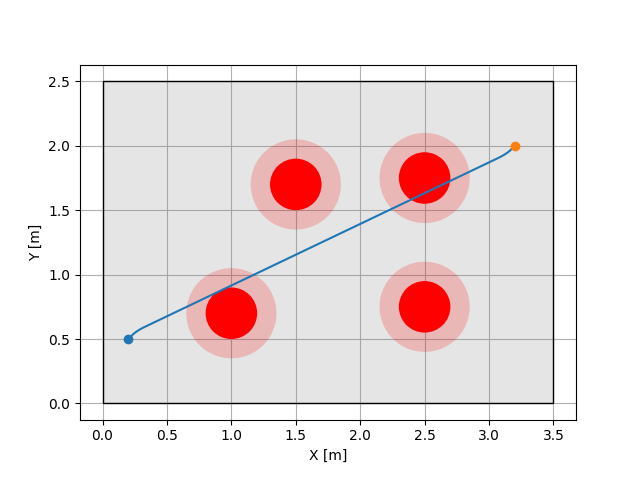

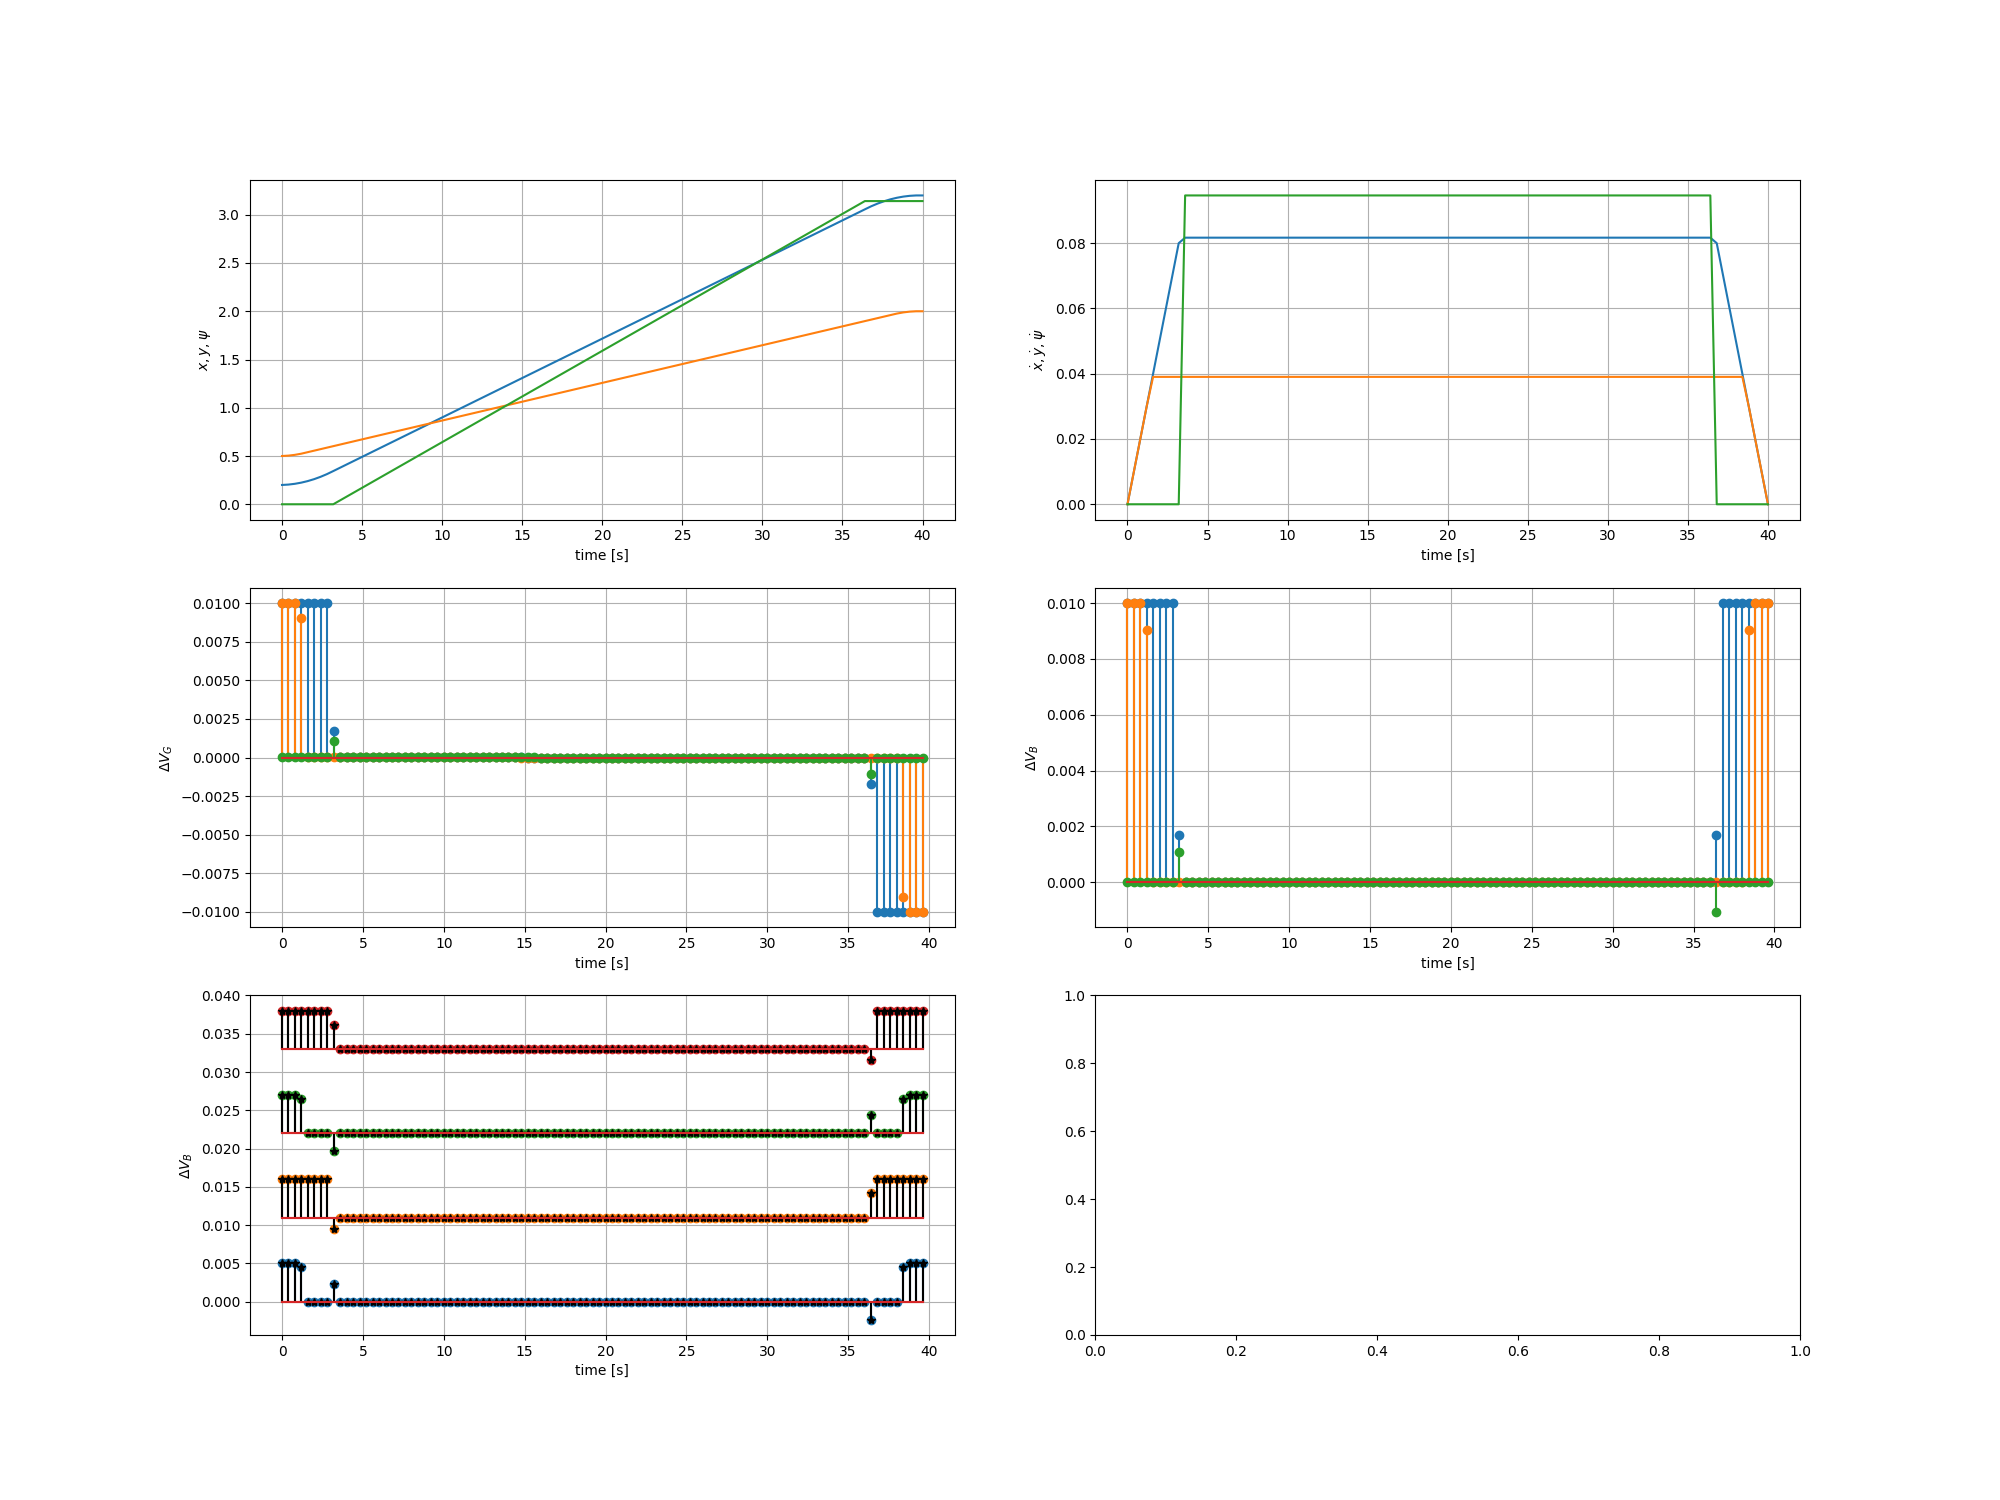

In [25]:
plot_scenario(traj_rel, ff_scenario.obs, state_init, state_final)

In [26]:
traj_scp, J_vect_scp, iter_scp, feas_scp = ocp_obstacle_avoidance(ff, traj_rel['states']+np.array([0,0,0,0,0,0]).reshape(-1,1), traj_rel['actions_G'], state_init, state_final)

In [27]:
iter_scp, J_vect_scp

(8,
 array([4.36549225e-01, 4.09065294e-01, 4.02705905e-01, 4.00217882e-01,
        3.99517856e-01, 3.99453140e-01, 3.98965965e-01, 3.98959782e-01,
        3.98959768e-01, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
        1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12,
        1.00000000e+12, 1.00000000e+12, 1.00000000e+12, 1.00000000e+12]))

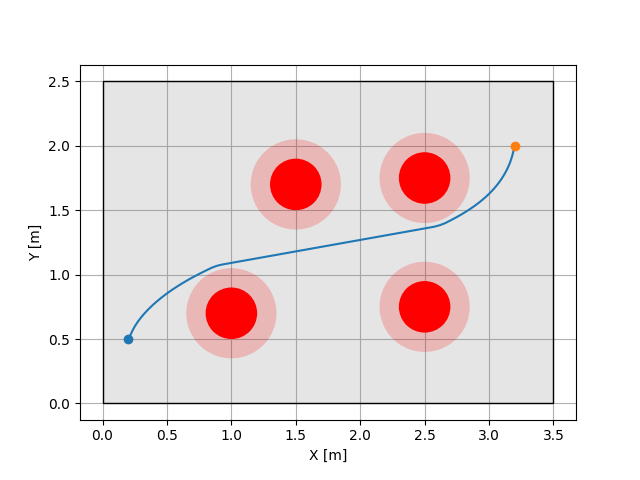

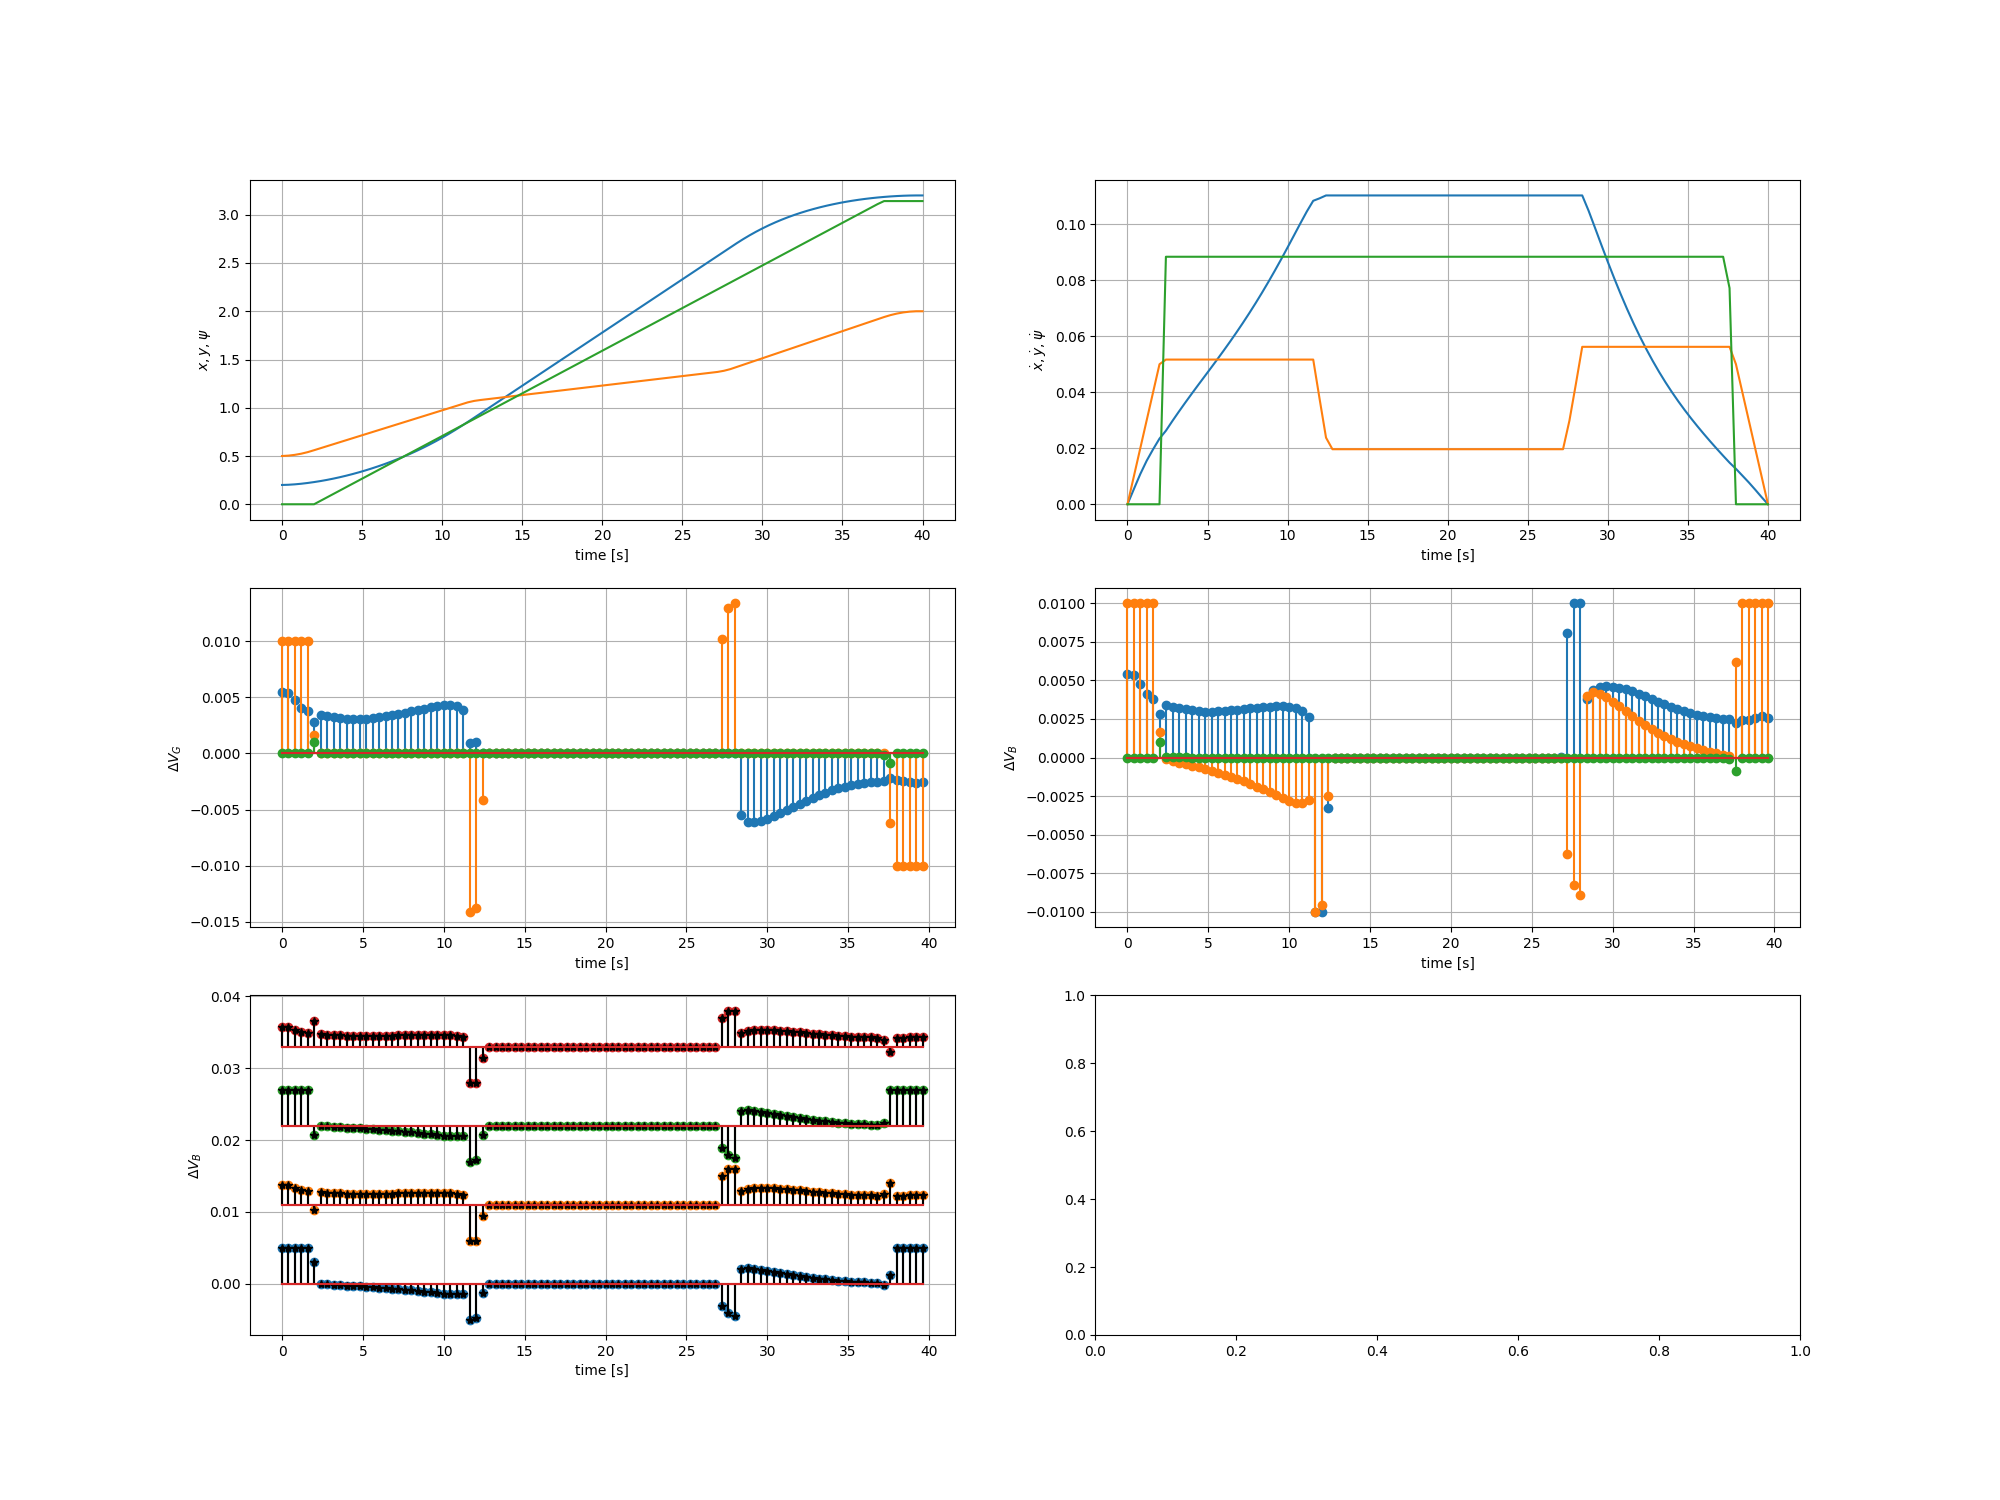

In [28]:
plot_scenario(traj_scp, ff_scenario.obs, state_init, state_final)